# 物件偵測專班 - YOLOv4 手把手教學

## 匯入所需套件

In [1]:
!pip install wandb pycocotools -q

In [2]:
import os
import cv2
import math
import yaml
import wandb
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import test
from models.models import *
from utils.general import labels_to_class_weights, fitness, strip_optimizer, check_img_size, bbox_iou
from utils.plots import plot_images, plot_labels, plot_lr_scheduler
from utils.datasets import get_hash, exif_size, load_image, load_mosaic, letterbox, random_perspective, augment_hsv

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline  

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## [貓狗資料集下載](https://public.roboflow.com/object-detection/oxford-pets/2/images/fc82071578629d4d44696cb666898d45)
<img src="slide_image/data_preview.png" width=1080/>

這個貓狗公開資料集提供了 3680 張影像，為了訓練快一點，這邊只取了 737 張影像來訓練：
- 訓練集: 663 張
- 驗證集: 74 張

這邊已經將檔案上傳到 google drive，可以直接用下面的指令下載並解壓縮，資料集結構如下：
```  
train
│
└───images (訓練用影像: 663) 
│   │   Abyssinian_101.jpg
│   │   Abyssinian_106.jpg
│   │   ...
│
└───labels (標記檔案: 663)
    │   Abyssinian_101.txt
    │   Abyssinian_106.txt
    │   ...
    
valid
│
└───images (驗證用影像: 74) 
│   │   Abyssinian_105.jpg
│   │   american_bulldog_10.jpg
│   │   ...
│   
└───labels (標記檔案: 74)
    │   Abyssinian_105.txt
    │   american_bulldog_10.txt
    │   ...
```

In [4]:
if not os.path.isdir('pet'):
    from utils.google_utils import *
    gdrive_download(id = '1UmDWcl4KrKLCNPyAXLNusI6agVZbKQHc', name='pet.zip')

創建 pet.yaml 裡面需要記錄：
1. 訓練集路徑: pet/train/images
2. 驗證集路徑: pet/valid/images
3. 類別數量: 2
4. 類別名稱: [cat, dog]

In [5]:
!echo -e 'train: pet/train/images\nval: pet/valid/images\n\nnc: 2\nnames: [cat, dog]' > data/pet.yaml
!head data/pet.yaml

train: pet/train/images
val: pet/valid/images

nc: 2
names: [cat, dog]


## 參數設置

In [6]:
# Parameters
project = 'runs/train'
name = 'exp'
data = 'data/pet.yaml'
cfg = 'cfg/yolov4.cfg'
hyp = 'data/hyp.scratch.yaml'
weights = 'yolov4.weights'
img_size = [416, 416]
batch_size = 4
epochs = 300
log_imgs = 16
workers = 8

'''
nbs 為模擬的 batch_size; 
例如上面設置的 batch_size 為 4, nbs 為 16
等於模型梯度累積了 16/4=4 (accumulate) 次之後
再更新一次模型，變相的擴大了 batch_size
'''
nbs = 16  # nominal batch size
accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing

# Hyperparameters
# 讀取 hyp 參數
with open(hyp) as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)  # load hyps

# 設置保存權重和 results 的路徑
save_dir = Path(project) / name 
wdir = save_dir / 'weights'
wdir.mkdir(parents=True, exist_ok=True)  # make dir
last = wdir / 'last.pt'
best = wdir / 'best.pt'
results_file = save_dir / 'results.txt'

# 保存 hyp 參數到自己的路徑下
with open(save_dir / 'hyp.yaml', 'w') as f:
    yaml.dump(hyp, f, sort_keys=False)

# 設置資料集路徑
with open(data) as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)  
train_path = data_dict['train']
test_path = data_dict['val']

# 獲取類別數量和類別名字
nc = int(data_dict['nc'])
names = data_dict['names'] 

# Configure
# 是否繪製訓練、測試圖片、指標圖等
plots = True  

## 使用 wandb 記錄訓練過程
- 先進入官網登入：https://wandb.ai/site 
- 右上方頭像 -> settings -> 複製 API keys -> 填入下方輸入處

In [7]:
# Logging
wandb_run = wandb.init(project='YOLOv4', name=save_dir.stem)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: d246810g2000 (use `wandb login --relogin` to force relogin)


# 訓練總覽
1. 資料前處理：讀取影像、資料增強
2. 建立 YOLOv4 模型：CSPDarknet53+SPP+PANet
3. 損失函數計算：正樣本匹配策略和 loss 函數定義
4. 優化器定義和學習率策略：Cosine annealing scheduler
5. 開始訓練：將訓練過程記錄到 wandb 裡面

## 1. 資料前處理：讀取影像、資料增強

In [8]:
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes

class LoadImagesAndLabels(torch.utils.data.Dataset):  # for training/testing
    def __init__(self, path, img_size=640, batch_size=16, augment=False, hyp=None, stride=32, pad=0.0):
        self.img_size = img_size
        self.augment = augment
        self.hyp = hyp
        self.mosaic = self.augment  # load 4 images at a time into a mosaic (only during training)
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.stride = stride

        def img2label_paths(img_paths):
            # Define label paths as a function of image paths
            sa, sb = os.sep + 'images' + os.sep, os.sep + 'labels' + os.sep  # /images/, /labels/ substrings
            return [x.replace(sa, sb, 1).replace(x.split('.')[-1], 'txt') for x in img_paths]
        
        # 得到 path 路徑下的所有圖片路徑 self.img_files
        try:
            f = []  # image files
            for p in path if isinstance(path, list) else [path]:
                p = Path(p)  # os-agnostic
                if p.is_dir():  # dir
                    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
                elif p.is_file():  # file
                    with open(p, 'r') as t:
                        t = t.read().splitlines()
                        parent = str(p.parent) + os.sep
                        f += [x.replace('./', parent) if x.startswith('./') else x for x in t]  # local to global path
                else:
                    raise Exception('%s does not exist' % p)
            self.img_files = sorted([x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in img_formats])
            assert self.img_files, 'No images found'
        except Exception as e:
            raise Exception('Error loading data from %s: %s' % (path, e))

        # 根據 imgs 路徑找到 labels 的路徑: self.label_files
        self.label_files = img2label_paths(self.img_files)  # labels
        # Check cache
        # 下次運行時直接從 cache 中取出 label，速度會更快
        cache_path = str(Path(self.label_files[0]).parent) + '.cache3'  # cached labels
        if os.path.isfile(cache_path):
            cache = torch.load(cache_path)  # load
            # 如果文件 hash 值對不上，說明資料集的圖片和標籤可能發生了變化，那就重新 cache label 文件
            if cache['hash'] != get_hash(self.label_files + self.img_files):  # dataset changed
                cache = self.cache_labels(cache_path)  # re-cache
        else:
            cache = self.cache_labels(cache_path)  # cache

        # Read cache
        cache.pop('hash')  # remove hash
        labels, shapes = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = np.array(shapes, dtype=np.float64)
        self.img_files = list(cache.keys())  # update
        self.label_files = img2label_paths(cache.keys())  # update

        n = len(shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(np.int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.imgs = [None] * n

    def cache_labels(self, path='labels.cache3'):
        # Cache dataset labels, check images and read shapes
        x = {}  # dict
        pbar = tqdm(zip(self.img_files, self.label_files), desc='Scanning images', total=len(self.img_files))
        for (img, label) in pbar:
            try:
                l = []
                im = Image.open(img)
                im.verify()  # PIL verify
                shape = exif_size(im)  # image size
                assert (shape[0] > 9) & (shape[1] > 9), 'image size <10 pixels'
                if os.path.isfile(label):
                    with open(label, 'r') as f:
                        l = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)  # labels
                if len(l) == 0:
                    l = np.zeros((0, 5), dtype=np.float32)
                x[img] = [l, shape]
            except Exception as e:
                print('WARNING: Ignoring corrupted image and/or label %s: %s' % (img, e))

        x['hash'] = get_hash(self.label_files + self.img_files)
        torch.save(x, path)  # save for next time
        return x

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        '''
        訓練 資料增強: mosaic(random_perspective) + hsv + 上下左右翻轉
        測試 資料增強: letterbox
        :return torch.from_numpy(img): 這個 index 的圖片數據(增強後) [3, 640, 640]
        :return labels_out: 這個 index 圖片的 gt label [6, 6] = [gt_num, 0+class+xywh(normalized)]
        :return self.img_files[index]: 這個 index 圖片的路徑地址
        :return shapes: 這個 batch 的圖片的 shapes 
        '''
        hyp = self.hyp # 裡面包含許多資料增強的超參數
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        if mosaic:
            # Load mosaic
            img, labels = load_mosaic(self, index)
            shapes = None

        else:
            # Load image
            # 載入圖片並進行 resize 將當前圖片的最長邊縮放到指定的大小 (img_size=640)，較小邊同比例縮放
            # 這一步是將 (350, 480, 3) resize-> (467, 640, 3)
            # img: resize 後的圖片, (h0, w0): 原始圖片的hw, (h, w): resize 後圖片的 hw
            img, (h0, w0), (h, w) = load_image(self, index)

            # Letterbox
            # letterbox 這一步將第一步縮放得到的圖片再縮放到當前 batch 所需要的尺度 
            # (467, 640, 3) + pad=(0.0, 13.5) -> (480, 640, 3)
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            # Load labels
            # 圖片 letterbox 之後 label 的座標也要相應變化，根據 pad 調整 label 座標，並將歸一化的 xywh -> 未歸一化的 xyxy
            labels = []
            x = self.labels[index]
            if x.size > 0:
                # Normalized xywh to pixel xyxy format
                labels = x.copy()
                labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
                labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
                labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]

        if self.augment:
            # Augment imagespace
            if not mosaic:
                # 不做 mosaic 的話就要做 random_perspective 增強 因為 mosaic 函數內部執行了 random_perspective 增強
                # random_perspective 增強: 隨機對圖片進行旋轉、平移、縮放、裁剪、透視變換
                img, labels = random_perspective(img, labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

            # Augment colorspace
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

        nL = len(labels)  # number of labels
        if nL:
            labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])  # convert xyxy to xywh
            labels[:, [2, 4]] /= img.shape[0]  # normalized height 0-1
            labels[:, [1, 3]] /= img.shape[1]  # normalized width 0-1
            
        # 平移增強：隨機左右翻轉 + 隨機上下翻轉
        if self.augment:
            # flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nL:
                    labels[:, 2] = 1 - labels[:, 2]

            # flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nL:
                    labels[:, 1] = 1 - labels[:, 1]

        labels_out = torch.zeros((nL, 6))
        if nL:
            labels_out[:, 1:] = torch.from_numpy(labels)

        # Convert
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), labels_out, self.img_files[index], shapes

    @staticmethod
    def collate_fn(batch):
        # 這邊將 batch 的 img 和 label 拼接起來，而這裡之所以拼接的方式不同 (stack or cat) 
        # 是因為 img 拼接的時候它的每個部分的形狀是相同的
        # 而 label 的每個部分的形狀不一定是相同的，因為每張圖的目標個數不一定相同
        img, label, path, shapes = zip(*batch)  # transposed
        for i, l in enumerate(label):
            l[:, 0] = i  # add target image index for build_targets()
        return torch.stack(img, 0), torch.cat(label, 0), path, shapes

In [9]:
def create_dataloader(path, imgsz, batch_size, stride, hyp=None, augment=False, shuffle=False, pad=0.0, world_size=1, workers=8):
    dataset = LoadImagesAndLabels(path, imgsz, batch_size,
                                  augment=augment,  # augment images
                                  hyp=hyp,  # augmentation hyperparameters
                                  stride=int(stride),
                                  pad=pad)

    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count() // world_size, batch_size if batch_size > 1 else 0, workers])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset, 
                                             batch_size=batch_size, 
                                             shuffle=shuffle,
                                             num_workers=nw,
                                             collate_fn=LoadImagesAndLabels.collate_fn)
    return dataloader, dataset

In [10]:
# Image sizes
# 獲取模型總步長和模型輸入圖片分辨率
gs = 32 # grid size (max stride)
# 檢查輸入圖片分辨率確保能夠整除總步長gs
imgsz, imgsz_test = [check_img_size(x, gs) for x in img_size]  # verify imgsz are gs-multiples

# Trainloader
dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, hyp=hyp, augment=True, shuffle=True)

# Testloader
testloader = create_dataloader(test_path, imgsz_test, batch_size*2, gs, hyp=hyp, shuffle=False)[0]  # testloader

### 看一下資料增強後的結果如何：

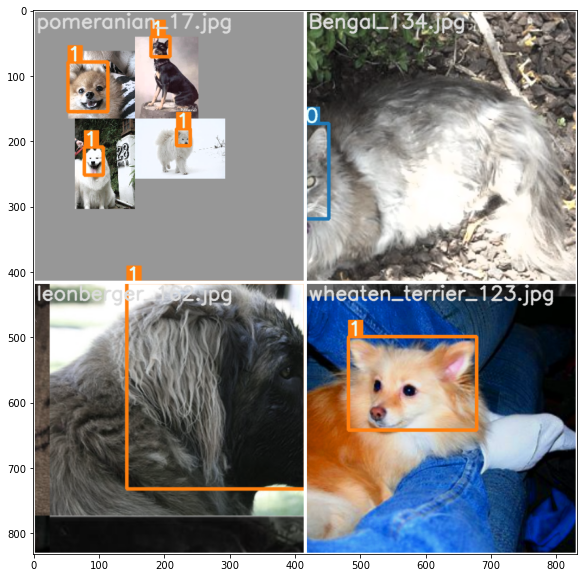

In [11]:
imgs, labels, paths, _ = next(iter(dataloader))
train_batch = plot_images(images=imgs, targets=labels, paths=paths, fname='train_batch_sample.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(train_batch)

## 2. 建立 YOLOv4 模型：CSPDarknet53+SPP+PANet
<img src="slide_image/yolov4_model.png" width=1080/>

In [12]:
# Model
model = Darknet(cfg).to(device) # create

# Model parameters
hyp['cls'] *= nc / 80.  # scale coco-tuned hyp['cls'] to current dataset
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
model.names = names

## 3. 損失函數計算：正樣本匹配策略和 loss 函數定義

### 正樣本匹配策略：從 label 建置符合條件的正樣本 target
選取正樣本採用了跨網格匹配規則，增加正樣本 anchor 數量的做法：對於任何一個輸出層，直接採用 shape 規則匹配，也就是該 bbox 和當前層的 anchor 計算寬高比，如果寬高比例大於設定閾值，則說明該 bbox 和 anchor 匹配度不夠，將該 bbox 過濾暫時丟掉，在該層預測中認為是背景，除了中心的 grid 外還找出最近的兩個 grid，將這三個 grid 都認為是負責預測該 bbox 的 anchor。

<img src="slide_image/target_grids.png" width=720/>

In [13]:
def build_targets(p, targets, model):
    """
    Build targets for compute_loss()
    :params p: 預測框 由模型構建中的三個 Detector 返回的三個 yolo 層的輸出
               如: [1, 3, 52, 52, 7]、[1, 3, 26, 26, 7]、[1, 3, 13, 13, 7]
               [bs, anchor_num, grid_h, grid_w, xywh+obj+classes]
    :params targets: 數據增強後的 label [1, 6] [num_target,  image_index+class+xywh] xywh 為正規化後的框
    :return tcls: 表示這個 target 所屬的 class index
            tbox: xywh 其中 xy 為這個 target 對當前 grid_cell 左上角的偏移量
            indices: b: 表示這個 target 屬於的 image index
                     a: 表示這個 target 使用的 anchor index
                    gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
                    gi: 表示這個網格的左上角 x 座標
            anch: 表示這個 target 所使用 anchor 的尺度（相對於這個feature map）
    """    
    nt = targets.shape[0]  # number of anchors, targets
    tcls, tbox, indices, anch = [], [], [], []
    # gain 是為了後面將 targets 中正規化的 xywh 映射到相對 feature map 尺度上
    gain = torch.ones(6, device=targets.device)  # normalized to gridspace gain
    # 以周圍 4 個網格來計算 offsets
    off = torch.tensor([[1, 0], [0, 1], [-1, 0], [0, -1]], device=targets.device).float()  # overlap offsets
    g = 0.5  # offset

    # 遍歷三個 feature 篩選每個 feature map 的每個 anchor 正樣本
    for i, jj in enumerate(model.yolo_layers):
        # get number of grid points and anchor vec for this yolo layer
        anchors = model.module_list[jj].anchor_vec
        gain[2:] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain

        # Match targets to anchors
        a, t, offsets = [], targets * gain, 0
        # 開始匹配
        if nt:
            na = anchors.shape[0]  # number of anchors
            at = torch.arange(na).view(na, 1).repeat(1, nt)  # anchor tensor, same as .repeat_interleave(nt)
            # anchor 與 label 的長寬比低於一定閾值就是正樣本
            r = t[None, :, 4:6] / anchors[:, None]  # wh ratio
            j = torch.max(r, 1. / r).max(2)[0] < model.hyp['anchor_t']  # compare
#             j = wh_iou(anchors, t[:, 4:6]) > model.hyp['iou_t']  
            # 根據篩選條件 j, 過濾負樣本, 得到當前 feature map 上三個 anchor 的所有 anchor index: a 與正樣本: t
            a, t = at[j], t.repeat(na, 1, 1)[j]  # filter

            # overlaps
            gxy = t[:, 2:4]  # grid xy
            z = torch.zeros_like(gxy)
            # 篩選中心座標 
            # 距離當前 grid_cell 的左、上方偏移小於 g=0.5 且 中心座標必須大於 1 (座標不能在邊上，此時就沒有4個格子了)
            # j: 如果是 True 表示當前 target 中心點所在的格子的左邊格子也對該 target 進行迴歸 (後續進行計算損失)
            # k: 如果是 True 表示當前 target 中心點所在的格子的上邊格子也對該 target 進行迴歸(後續進行計算損失)
            j, k = ((gxy % 1. < g) & (gxy > 1.)).T
            # 距離當前 grid_cell 的右、下方偏移小於 g=0.5 且 中心座標必須大於 1 (座標不能在邊上，此時就沒有4個格子了)
            # l: 如果是 True 表示當前 target 中心點所在的格子的右邊格子也對該 target 進行迴歸 (後續進行計算損失)
            # m: 如果是 True 表示當前 target 中心點所在的格子的下邊格子也對該 target 進行迴歸 (後續進行計算損失)
            l, m = ((gxy % 1. > (1 - g)) & (gxy < (gain[[2, 3]] - 1.))).T
            a, t = torch.cat((a, a[j], a[k], a[l], a[m]), 0), torch.cat((t, t[j], t[k], t[l], t[m]), 0)
            # 得到所有篩選後的網格的中心相對於這個要預測的 label 所在網格邊界（左右上下邊框）的偏移量
            offsets = torch.cat((z, z[j] + off[0], z[k] + off[1], z[l] + off[2], z[m] + off[3]), 0) * g

        # Define
        b, c = t[:, :2].long().T  # image index, class
        gxy = t[:, 2:4]  # grid xy
        gwh = t[:, 4:6]  # grid wh
        gij = (gxy - offsets).long()
        gi, gj = gij.T  # grid xy indices

        # Append
        #indices.append((b, a, gj, gi))  # image, anchor, grid indices
        indices.append((b, a, gj.clamp_(0, gain[3] - 1), gi.clamp_(0, gain[2] - 1)))  # image, anchor, grid indices
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        anch.append(anchors[a])  # anchors
        tcls.append(c)  # class

    return tcls, tbox, indices, anch

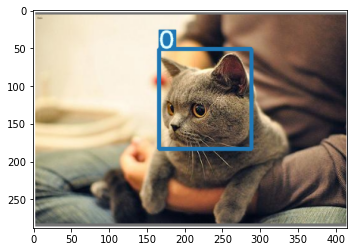

In [14]:
img_path = 'pet/train/images/British_Shorthair_100.jpg'
label_path = 'pet/train/labels/British_Shorthair_100.txt'
img0 = cv2.imread(img_path).astype('float32')
img_pad = letterbox(img0, new_shape=img_size, auto_size=32)[0]
img = img_pad[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
img = np.ascontiguousarray(img)
img = torch.from_numpy(img).to(device)
img /= 255.0
img = torch.unsqueeze(img, 0)
h, w = img.shape[-2:]
p = model(img)

with open(label_path, 'r') as f:
    label = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)  # labels
label = np.insert(label, 0, 0)
targets = torch.from_numpy(label).to(device)
targets = torch.unsqueeze(targets, 0)
vis_label = plot_images(img, targets)
plt.imshow(vis_label)

In [15]:
targets

tensor([[0.00000, 0.00000, 0.54700, 0.40813, 0.29400, 0.46084]], device='cuda:0')

In [16]:
tcls, tbox, indices, anchors = build_targets(p, targets, model)  # targets

#### tcls: 表示這個 target 所屬的 class index

In [17]:
tcls

[tensor([], device='cuda:0', dtype=torch.int64),
 tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')]

#### tbox: xywh 其中 xy 為這個 target 對當前 grid_cell 左上角的偏移量

In [18]:
tbox

[tensor([], device='cuda:0', size=(0, 4)),
 tensor([[0.22200, 0.34639, 7.64400, 8.29518],
         [0.22200, 0.34639, 7.64400, 8.29518],
         [1.22200, 0.34639, 7.64400, 8.29518],
         [1.22200, 0.34639, 7.64400, 8.29518],
         [0.22200, 1.34639, 7.64400, 8.29518],
         [0.22200, 1.34639, 7.64400, 8.29518]], device='cuda:0'),
 tensor([[ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 1.11100,  0.67319,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759],
         [ 0.11100, -0.32681,  3.82200,  4.14759]], device='cuda:0')]

#### anchors: 表示這個 target 所使用 anchor 的尺度（相對於這個feature map）

In [19]:
anchors

[tensor([], device='cuda:0', size=(0, 2)),
 tensor([[3.87500, 2.81250],
         [3.68750, 7.43750],
         [3.87500, 2.81250],
         [3.68750, 7.43750],
         [3.87500, 2.81250],
         [3.68750, 7.43750]], device='cuda:0'),
 tensor([[ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750],
         [ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750],
         [ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750]], device='cuda:0')]

In [20]:
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
anch_masks = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
strides = np.array([8, 16, 32])
anchor_vec = []
for i in range(3):
    anc = []
    for j in range(3):
        anc.append(anchors[anch_masks[i][j]]/strides[i])
    anchor_vec.append(anc)
anchor_vec

[[array([       1.25,       1.625]),
  array([          2,        3.75]),
  array([      4.125,       2.875])],
 [array([      1.875,      3.8125]),
  array([      3.875,      2.8125]),
  array([     3.6875,      7.4375])],
 [array([      3.625,      2.8125]),
  array([      4.875,      6.1875]),
  array([     11.656,      10.188])]]

#### indices:
- b: 表示這個 target 屬於的 image index
- a: 表示這個 target 使用的 anchor index
- gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
- gi: 表示這個網格的左上角 x 座標

In [21]:
indices

[(tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 (tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([1, 2, 1, 2, 1, 2]),
  tensor([7, 7, 7, 7, 6, 6], device='cuda:0'),
  tensor([14, 14, 13, 13, 14, 14], device='cuda:0')),
 (tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
  tensor([3, 3, 3, 3, 3, 3, 4, 4, 4], device='cuda:0'),
  tensor([7, 7, 7, 6, 6, 6, 7, 7, 7], device='cuda:0'))]

### 解說三層 yolo layer 分別輸出的 target 

In [22]:
x, y = label[2:4]
x_, y_ = x*w, y*h

#### 1. stride=8: 偵測小物體，anchor: [10, 13], [16, 30], [33, 23]

In [23]:
grid = (w/8, h/8)
grid

(52.0, 36.0)

In [24]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[0]

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

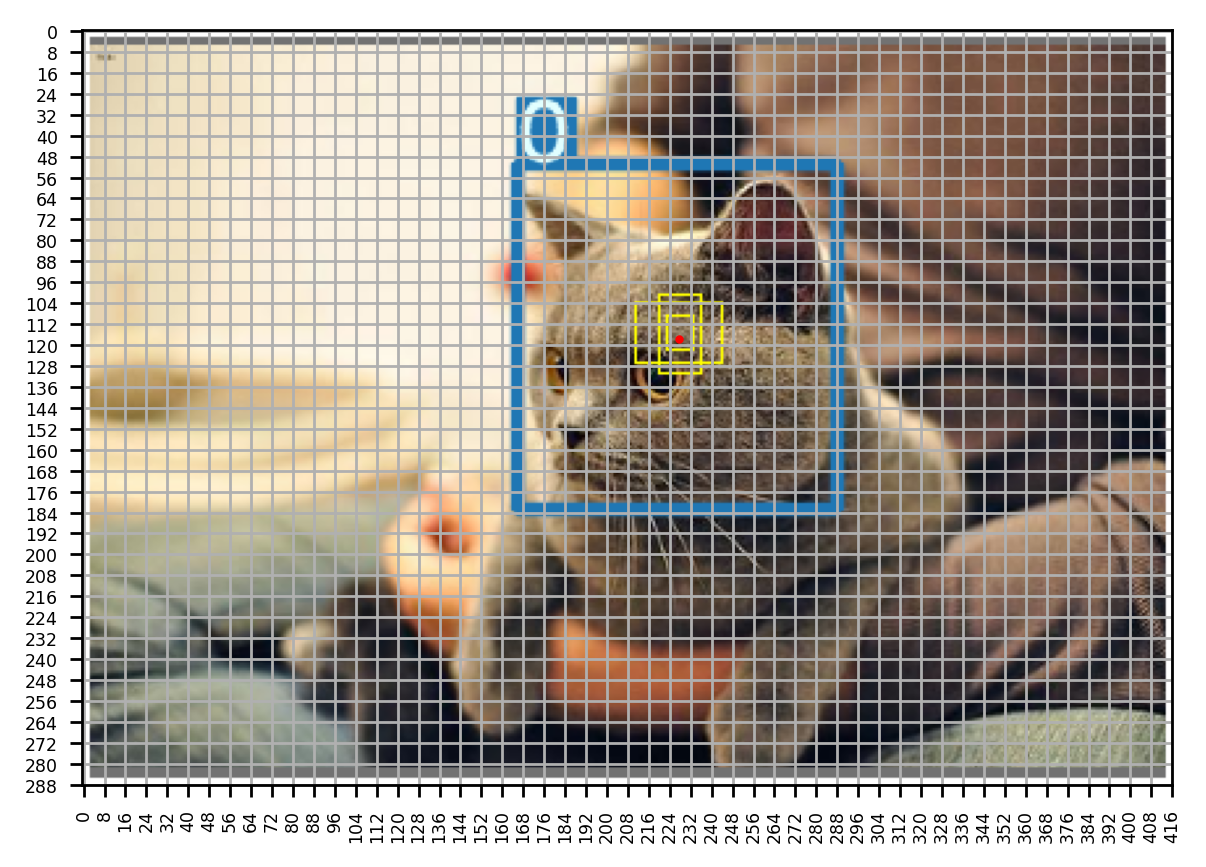

In [25]:
anchor_1 = [[10, 13], [16, 30], [33, 23]]
anc_xy_1 = []
for anc_w, anc_h in anchor_1:
    anc_x1y1 = (int(28*8+4-anc_w/2), int(14*8+4-anc_h/2))
    anc_x2y2 = (int(28*8+4+anc_w/2), int(14*8+4+anc_h/2))
    anc_xy_1.append((anc_x1y1, anc_x2y2))

fig, ax = plt.subplots()
fig.set_dpi(250)
vis_label = plot_images(img, targets)
for anc in anc_xy_1: 
    cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 1)
ax.imshow(vis_label)
ax.scatter(x_, y_, c='red', s=2)
ax.set_xticks(8*(np.arange(grid[0]+1)))
ax.set_yticks(8*(np.arange(grid[1]+1)))
ax.grid()
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
ax.tick_params(axis='y', labelsize=5)

#### 2. stride=16: 偵測中物體，anchor: [30, 61], [62, 45], [59, 119]

In [26]:
grid = (w/16, h/16)
grid

(26.0, 18.0)

In [27]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[1]

(tensor([0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 2, 1, 2, 1, 2]),
 tensor([7, 7, 7, 7, 6, 6], device='cuda:0'),
 tensor([14, 14, 13, 13, 14, 14], device='cuda:0'))

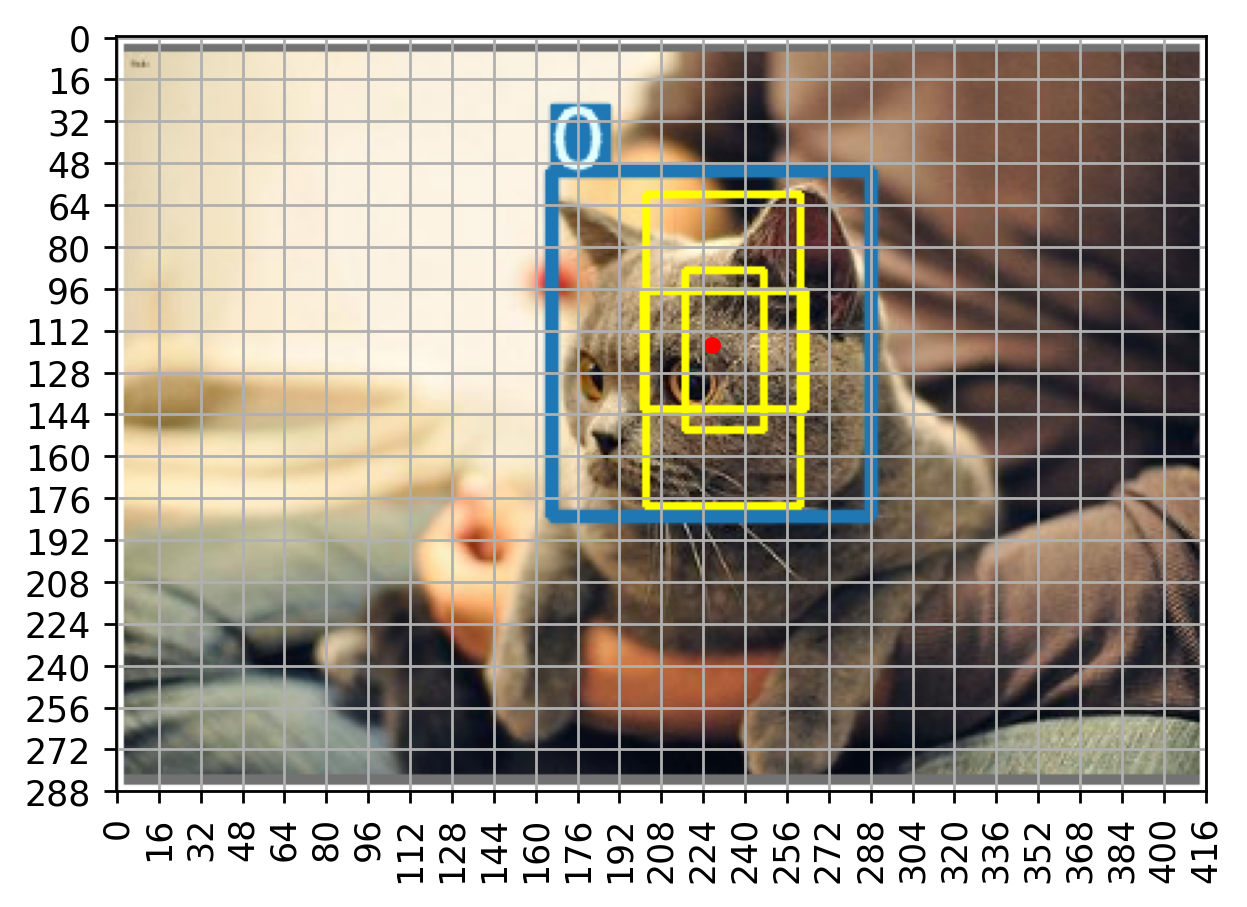

In [28]:
anchor_2 = [[30, 61], [62, 45], [59, 119]]
anc_xy_2 = []
for anc_w, anc_h in anchor_2:
    anc_x1y1 = (int(14*16+8-anc_w/2), int(7*16+8-anc_h/2))
    anc_x2y2 = (int(14*16+8+anc_w/2), int(7*16+8+anc_h/2))
    anc_xy_2.append((anc_x1y1, anc_x2y2))

fig, ax = plt.subplots()
fig.set_dpi(250)
vis_label = plot_images(img, targets)
for anc in anc_xy_2: 
    cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 2)
ax.imshow(vis_label)
ax.scatter(x_, y_, c='red', s=15)
ax.set_xticks(16*(np.arange(grid[0]+1)))
ax.set_yticks(16*(np.arange(grid[1]+1)))
ax.grid()
ax.tick_params(axis='x', labelrotation=90)

#### 3. stride=32: 偵測大物體，anchor: [116, 90], [156, 198], [373, 326]

In [29]:
grid = (w/32, h/32)
grid

(13.0, 9.0)

In [30]:
# indices: b: 表示這個 target 屬於的 image index
#          a: 表示這個 target 使用的 anchor index
#         gj: 經過篩選後確定某個 target 在某個網格中進行預測(計算損失)  gj表示這個網格的左上角y座標
#         gi: 表示這個網格的左上角 x 座標
indices[2]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]),
 tensor([3, 3, 3, 3, 3, 3, 4, 4, 4], device='cuda:0'),
 tensor([7, 7, 7, 6, 6, 6, 7, 7, 7], device='cuda:0'))

#### 這邊我們把對應的所有正樣本都畫出來給各位看

In [31]:
anchor_3 = [[116, 90], [156, 198], [373, 326]]
anc_xy_3 = []
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(7*32+16-anc_w/2), int(3*32+16-anc_h/2))
    anc_x2y2 = (int(7*32+16+anc_w/2), int(3*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))
    
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(6*32+16-anc_w/2), int(3*32+16-anc_h/2))
    anc_x2y2 = (int(6*32+16+anc_w/2), int(3*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))
    
for anc_w, anc_h in anchor_3:
    anc_x1y1 = (int(7*32+16-anc_w/2), int(4*32+16-anc_h/2))
    anc_x2y2 = (int(7*32+16+anc_w/2), int(4*32+16+anc_h/2))
    anc_xy_3.append((anc_x1y1, anc_x2y2))

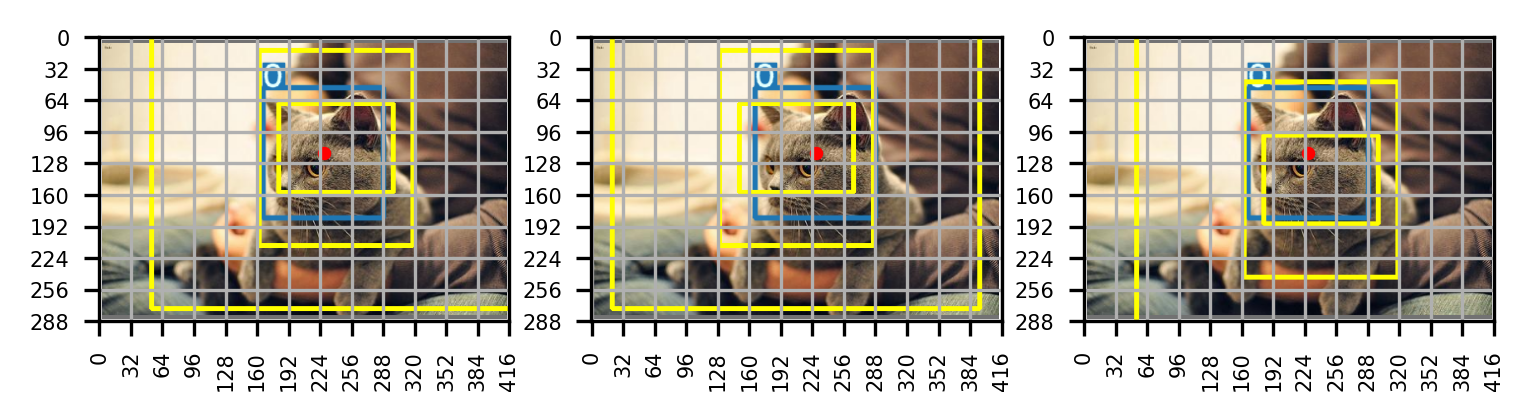

In [32]:
fig, ax = plt.subplots(1, 3)
fig.set_dpi(300)
for i in range(3):
    vis_label = plot_images(img, targets)
    for anc in anc_xy_3[3*i:3*(i+1)]: 
        cv2.rectangle(vis_label, anc[0], anc[1], [255, 255, 0], 3)
    ax[i].imshow(vis_label)
    ax[i].scatter(x_, y_, c='red', s=5)
    ax[i].set_xticks(32*(np.arange(grid[0]+1)))
    ax[i].set_yticks(32*(np.arange(grid[1]+1)))
    ax[i].grid()
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=5)
    ax[i].tick_params(axis='y', labelsize=5)

### loss 函數定義

In [33]:
from utils.loss import smooth_BCE
def compute_loss(p, targets, model):  # predictions, targets, model
    device = targets.device
    
    # 初始化 lcls, lbox, lobj 三種損失值 tensor([0.])
    lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)
    tcls, tbox, indices, anchors = build_targets(p, targets, model)  # targets
    h = model.hyp  # hyperparameters

    # Define criteria
    BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([h['cls_pw']])).to(device)
    BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([h['obj_pw']])).to(device)

    # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
    cp, cn = smooth_BCE(eps=0.0)

    # Losses
    nt = 0  # number of targets
    no = len(p)  # number of outputs
    
    # balance 用來設置三個 feature map 對應輸出的置信度損失係數 (平衡三個 feature map 的置信度損失)
    # 從左到右分別對應大 feature map (偵測小目標) 到小 feature map (偵測大目標)
    # 思路：一般來說，偵測小物體的難度大一點，所以會增加大特徵圖的損失係數，讓模型更加側重小物體的偵測
    balance = [4.0, 1.0, 0.4] if no == 3 else [4.0, 1.0, 0.4, 0.1]  # P3-5 or P3-6
    balance = [4.0, 1.0, 0.5, 0.4, 0.1] if no == 5 else balance
    for i, pi in enumerate(p):  # layer index, layer predictions
        b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
        tobj = torch.zeros_like(pi[..., 0], device=device)  # target obj

        n = b.shape[0]  # number of targets
        if n:
            nt += n  # cumulative targets
            ps = pi[b, a, gj, gi]  # prediction subset corresponding to targets

            # Regression
            pxy = ps[:, :2].sigmoid() * 2. - 0.5
            pwh = (ps[:, 2:4].sigmoid() * 2) ** 2 * anchors[i]
            pbox = torch.cat((pxy, pwh), 1).to(device)  # predicted box
            iou = bbox_iou(pbox.T, tbox[i], x1y1x2y2=False, CIoU=True)  # iou(prediction, target)
            lbox += (1.0 - iou).mean()  # iou loss

            # Objectness
            tobj[b, a, gj, gi] = (1.0 - model.gr) + model.gr * iou.detach().clamp(0).type(tobj.dtype)  # iou ratio

            # Classification
            if model.nc > 1:  # cls loss (only if multiple classes)
                t = torch.full_like(ps[:, 5:], cn, device=device)  # targets
                t[range(n), tcls[i]] = cp
                lcls += BCEcls(ps[:, 5:], t)  # BCE

        lobj += BCEobj(pi[..., 4], tobj) * balance[i]  # obj loss

    s = 3 / no  # output count scaling
    lbox *= h['box'] * s
    lobj *= h['obj'] * s * (1.4 if no >= 4 else 1.)
    lcls *= h['cls'] * s
    bs = tobj.shape[0]  # batch size

    loss = lbox + lobj + lcls
    return loss * bs, torch.cat((lbox, lobj, lcls, loss)).detach()

## 4. 優化器定義和學習率策略

### SGD+CosineAnnealingLR

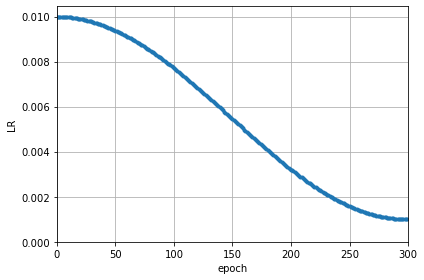

In [34]:
optimizer = optim.SGD(model.parameters(), 
                      lr=hyp['lr0'],
                      momentum=hyp['momentum'],
                      nesterov=True)  
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=hyp['lr0']*hyp['lrf'])
plot_lr_scheduler(optimizer, scheduler, epochs)

### AdamW+CosineAnnealingWarmRestarts

In [35]:
# optimizer = optim.AdamW(model.parameters(), 
#                         lr=hyp['lr0'],
#                         betas=(hyp['momentum'], 0.999),
#                         weight_decay=hyp['weight_decay'])  
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=101, T_mult=2, eta_min=hyp['lr0']*hyp['lrf'])
# plot_lr_scheduler(optimizer, scheduler, epochs)

## 5. 開始訓練

In [ ]:
# Start training
# best_fitness是以 [0.0, 0.0, 0.1, 0.9] 為係數並乘以 [precision, recall, mAP@0.5, mAP@0.5:0.95] 再求和所得
best_fitness = 0.0
nb = len(dataloader)  # number of batches
results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
# 儲存初始模型權重
torch.save(model, wdir / 'init.pt')

scheduler.step(0)
for epoch in range(1, epochs+1):  # epoch ------------------------------------------------------------------
    model.train()
    mloss = torch.zeros(4, device=device)  # mean losses
    pbar = enumerate(dataloader)
    pbar = tqdm(pbar, total=nb)  # progress bar
    for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
        # 計算迭代的次數 iteration
        ni = i + nb * epoch  # number integrated batches (since train start)
        imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0    
        
        # Multi-scale
        sz = random.randrange(imgsz * 0.75, imgsz * 1.25 + gs) // gs * gs  # size
        sf = sz / max(imgs.shape[2:])  # scale factor
        if sf != 1:
            ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
            imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

        # Forward
        pred = model(imgs)  # forward
        # 計算損失，包括分類損失，objectness損失，框的迴歸損失
        # loss為總損失值，loss_items為一個元組，包含分類損失，objectness損失，框的迴歸損失和總損失
        loss, loss_items = compute_loss(pred, targets.to(device), model)  # loss scaled by batch_size

        # Backward
        loss.backward()

        # Optimize
        # 模型反向傳播 accumulate 次之後再根據累積的梯度更新一次參數
        if ni % accumulate == 0:
            optimizer.step()  # optimizer.step
            optimizer.zero_grad()

        # Print
        # 印出進行的輪次, 記憶體佔用量, box_loss, obj_loss, cls_loss, total_loss, target 的數量, 圖片的 size
        mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        s = ('%10s' * 2 + '%10.4g' * 6) % (
            '%g/%g' % (epoch, epochs), mem, *mloss, targets.shape[0], imgs.shape[-1])
        pbar.set_description(s)

        # Plot
        # 將前三次迭代 batch 的標籤框在圖片上畫出來並記錄到 wandb 上
        if plots and ni < 3:
            f = save_dir / f'train_batch{ni}.jpg'  # filename
            plot_images(images=imgs, targets=targets, paths=paths, fname=f)
        elif plots and ni == 3 and wandb:
            wandb.log({"Mosaics": [wandb.Image(str(x), caption=x.name) for x in save_dir.glob('train*.jpg')]})

        # end batch ------------------------------------------------------------------------------------------------
    # end epoch ----------------------------------------------------------------------------------------------------

    # Scheduler
    # 進行學習率衰減
    lr = scheduler.get_lr()  # for tensorboard
    scheduler.step()

    # 5 個 epoch 驗證一次驗證集，並計算 mAP 等指標
    if epoch%5==0:
        results, maps, times = test.test(data,
                                     batch_size=batch_size*2,
                                     imgsz=imgsz_test,
                                     model=model,
                                     dataloader=testloader,
                                     save_dir=save_dir,
                                     plots=plots,
                                     log_imgs=log_imgs)

    # Write
    # 將指標寫入 result.txt
    with open(results_file, 'a') as f:
        f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)

    # Log
    # 添加指標到 wandb 中
    tags = ['train/box_loss', 'train/obj_loss', 'train/cls_loss',  # train loss
            'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95',
            'val/box_loss', 'val/obj_loss', 'val/cls_loss',  # val loss
            'x/lr']  # params
    for x, tag in zip(list(mloss[:-1]) + list(results) + lr, tags):
        wandb.log({tag: x})  # W&B

    # Update best mAP
    fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
    if fi > best_fitness:
        best_fitness = fi

    # Save model
    with open(results_file, 'r') as f:  # create checkpoint
        ckpt = {'epoch': epoch,
                'best_fitness': best_fitness,
                'training_results': f.read(),
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'wandb_id': wandb_run.id}

    # Save last, best and delete
    torch.save(ckpt, last)
    if best_fitness == fi:
        torch.save(ckpt, best)
    del ckpt
    # end epoch ----------------------------------------------------------------------------------------------------
# end training

wandb.run.finish()
torch.cuda.empty_cache()

     1/300     9.35G   0.09481   0.03275   0.01539    0.1429        10       384: 100%|██████████| 166/166 [00:35<00:00,  4.63it/s]
     2/300     9.35G   0.08638   0.03426    0.0142    0.1348         6       512: 100%|██████████| 166/166 [00:36<00:00,  4.58it/s]
     3/300     9.35G   0.08463   0.03648   0.01425    0.1354         5       352: 100%|██████████| 166/166 [00:36<00:00,  4.60it/s]
     4/300     9.35G    0.0838   0.03663     0.014    0.1344         5       384: 100%|██████████| 166/166 [00:35<00:00,  4.69it/s]
     5/300     9.35G   0.08294   0.03599   0.01431    0.1332         3       480: 100%|██████████| 166/166 [00:35<00:00,  4.63it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


                 all          74          74           0           0     0.00774     0.00164


     6/300     9.51G   0.08128   0.03738   0.01412    0.1328         7       416: 100%|██████████| 166/166 [00:36<00:00,  4.59it/s]
     7/300     9.51G   0.08003   0.03637   0.01401    0.1304        13       512:  77%|███████▋  | 127/166 [00:27<00:10,  3.86it/s]

In [ ]:
nuctl create project cvat
nuctl deploy --project-name cvat \
  --path serverless/openvino/dextr/nuclio \
  --volume 'pwd'/serverless/openvino/common:/opt/nuclio/common \
  --platform local